In [9]:
# =================================================
# 1. Import libraries & Load Raw CSVs
# =================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load raw data
students_df = pd.read_csv("students_identification_14k.csv")
attendance_df = pd.read_csv("attendance_14k_90days.csv")
tests_df = pd.read_csv("tests_14k_4tests.csv")
fees_df = pd.read_csv("fees_14k.csv")

print("✅ Raw files loaded")
print("Students:", students_df.shape)
print("Attendance:", attendance_df.shape)
print("Tests:", tests_df.shape)
print("Fees:", fees_df.shape)


✅ Raw files loaded
Students: (14000, 6)
Attendance: (1260000, 3)
Tests: (14000, 5)
Fees: (14000, 7)


In [10]:
# =================================================
# 2. Clean & Standardize
# =================================================

# --- Students ---
students_df.dropna(inplace=True)  # drop missing rows

# --- Attendance ---
attendance_df.dropna(inplace=True)
attendance_df["present"] = attendance_df["present"].astype(int)

# --- Tests ---
tests_df.fillna(tests_df.mean(numeric_only=True), inplace=True)  # fill missing scores
for col in tests_df.columns[1:]:
    tests_df[col] = pd.to_numeric(tests_df[col], errors="coerce").fillna(0)

# --- Fees ---
fees_df.fillna({"Fee_Status": "Pending", "Fee_Due_Days": 0, "Scholarship_Eligibility": "No"}, inplace=True)
fees_df["Fee_Due_Days"] = pd.to_numeric(fees_df["Fee_Due_Days"], errors="coerce").fillna(0).astype(int)

print("✅ Data cleaned & standardized")


✅ Data cleaned & standardized


In [11]:
# =================================================
# 3. Build Attendance Summary
# =================================================

# Overall attendance %
attendance_summary = attendance_df.groupby("Student_ID")["present"].mean().reset_index()
attendance_summary["Attendance_Percentage"] = (attendance_summary["present"] * 100).round(1)
attendance_summary.drop(columns="present", inplace=True)

# Monthly attendance (last 30 days per student)
last_30_days = attendance_df.groupby("Student_ID").tail(30).groupby("Student_ID")["present"].mean().reset_index()
last_30_days.rename(columns={"present": "Monthly_Attendance"}, inplace=True)
last_30_days["Monthly_Attendance"] = (last_30_days["Monthly_Attendance"] * 100).round(1)

# Merge both summaries
attendance_summary = pd.merge(attendance_summary, last_30_days, on="Student_ID", how="left")

print("✅ Attendance summary created")
attendance_summary.head()


✅ Attendance summary created


,Student_ID,Attendance_Percentage,Monthly_Attendance
0,S00001,72.2,76.7
1,S00002,81.1,86.7
2,S00003,75.6,80.0
3,S00004,82.2,83.3
4,S00005,93.3,93.3


In [12]:
# =================================================
# 4. Build Test Score Summary
# =================================================

# Average & last test score
tests_df["Avg_Test_Score"] = tests_df.iloc[:, 1:].mean(axis=1).round(1)
tests_df["Last_Test_Score"] = tests_df.iloc[:, -1]

# Subjects failed (<40 marks)
tests_df["Subjects_Failed"] = (tests_df.iloc[:, 1:-2] < 40).sum(axis=1)

# Attempts exhausted (if failed > 2 subjects)
tests_df["Attempts_Exhausted"] = np.where(tests_df["Subjects_Failed"] > 2, 1, 0)

print("✅ Test score summary created")
tests_df.head()


✅ Test score summary created


,Student_ID,Test1_Score,Test2_Score,Test3_Score,Test4_Score,Avg_Test_Score,Last_Test_Score,Subjects_Failed,Attempts_Exhausted
0,S00001,70,57,46,63,59.0,59.0,0,0
1,S00002,59,69,40,66,58.5,58.5,0,0
2,S00003,73,64,64,58,64.8,64.8,0,0
3,S00004,100,76,74,95,86.2,86.2,0,0
4,S00005,69,78,99,81,81.8,81.8,0,0


In [13]:
# =================================================
# 5. Merge All Data Sources
# =================================================
merged = students_df.merge(attendance_summary, on="Student_ID", how="left")
merged = merged.merge(
    tests_df[["Student_ID","Avg_Test_Score","Last_Test_Score","Subjects_Failed","Attempts_Exhausted"]],
    on="Student_ID", how="left"
)
merged = merged.merge(fees_df, on="Student_ID", how="left")

print("✅ All datasets merged")
merged.head()


✅ All datasets merged


,Student_ID,Name,Roll_No,Department,Semester,Mentor_ID,Attendance_Percentage,Monthly_Attendance,Avg_Test_Score,Last_Test_Score,Subjects_Failed,Attempts_Exhausted,Fee_Total,Fee_Paid,Fee_Due_Amount,Fee_Status,Fee_Due_Days,Scholarship_Eligibility
0,S00001,Ankita Mishra,R000001,CE,1,M084,72.2,76.7,59.0,59.0,0,0,50000,50000,0,Paid,0,No
1,S00002,Kavya Saxena,R000002,ECE,7,M096,81.1,86.7,58.5,58.5,0,0,50000,50000,0,Paid,0,Yes
2,S00003,Siddharth Banerjee,R000003,CE,5,M081,75.6,80.0,64.8,64.8,0,0,55000,24774,30226,Partial,96,No
3,S00004,Rohan Yadav,R000004,CSE,5,M057,82.2,83.3,86.2,86.2,0,0,50000,50000,0,Paid,0,No
4,S00005,Priya Reddy,R000005,IT,7,M106,93.3,93.3,81.8,81.8,0,0,50000,50000,0,Paid,0,No


In [14]:
# =================================================
# 6. Define Risk Thresholds
# =================================================
merged["Attendance_Flag"] = (merged["Attendance_Percentage"] < 60).astype(int)
merged["Score_Flag"] = (merged["Avg_Test_Score"] < 40).astype(int)
merged["Attempts_Flag"] = (merged["Attempts_Exhausted"] > 2).astype(int)
merged["Fee_Flag"] = (merged["Fee_Due_Days"] > 30).astype(int)

merged["Total_Risk_Flags"] = merged[["Attendance_Flag","Score_Flag","Attempts_Flag","Fee_Flag"]].sum(axis=1)

print("✅ Risk thresholds applied")
merged[["Student_ID","Attendance_Flag","Score_Flag","Fee_Flag","Total_Risk_Flags"]].head()


✅ Risk thresholds applied


,Student_ID,Attendance_Flag,Score_Flag,Fee_Flag,Total_Risk_Flags
0,S00001,0,0,0,0
1,S00002,0,0,0,0
2,S00003,0,0,1,1
3,S00004,0,0,0,0
4,S00005,0,0,0,0


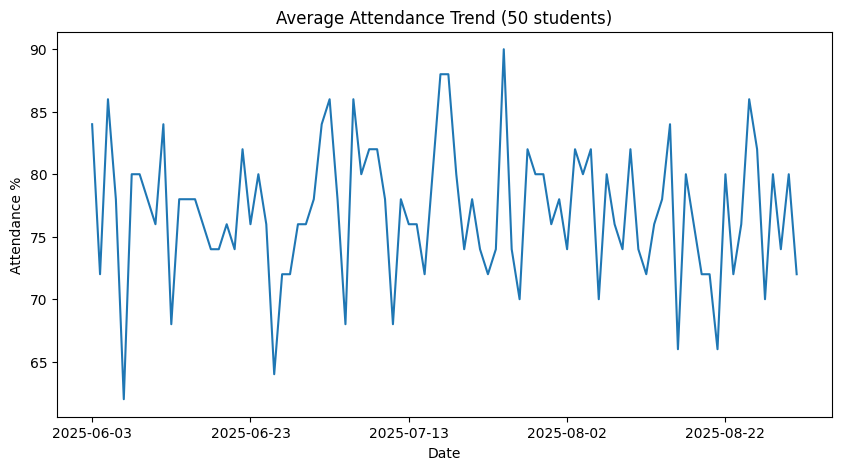

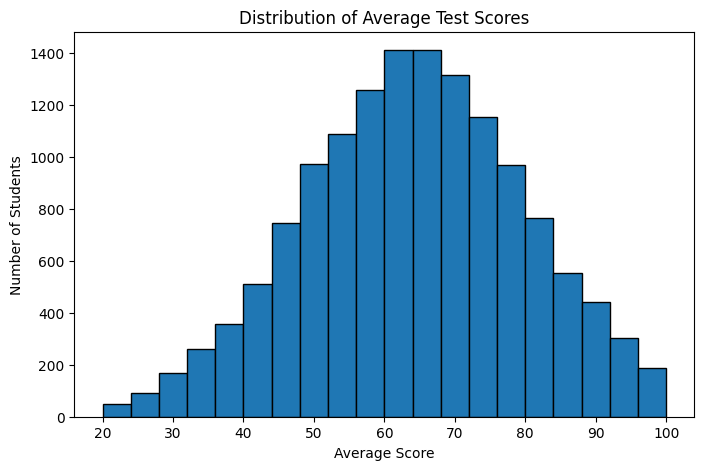

In [20]:
# =================================================
# 7. Trend Analysis (Graphs)
# =================================================

# Attendance trend (sample 50 students)
sample_ids = np.random.choice(attendance_df["Student_ID"].unique(), 50, replace=False)
sample_attendance = attendance_df[attendance_df["Student_ID"].isin(sample_ids)]
trend = sample_attendance.groupby("date")["present"].mean() * 100  # fixed 'date'

plt.figure(figsize=(10,5))
trend.plot()
plt.title("Average Attendance Trend (50 students)")  # removed emoji for safety
plt.ylabel("Attendance %")
plt.xlabel("Date")
plt.show()

# Score distribution
plt.figure(figsize=(8,5))
plt.hist(merged["Avg_Test_Score"], bins=20, edgecolor="black")
plt.title("Distribution of Average Test Scores")  # removed emoji for safety
plt.xlabel("Average Score")
plt.ylabel("Number of Students")
plt.show()


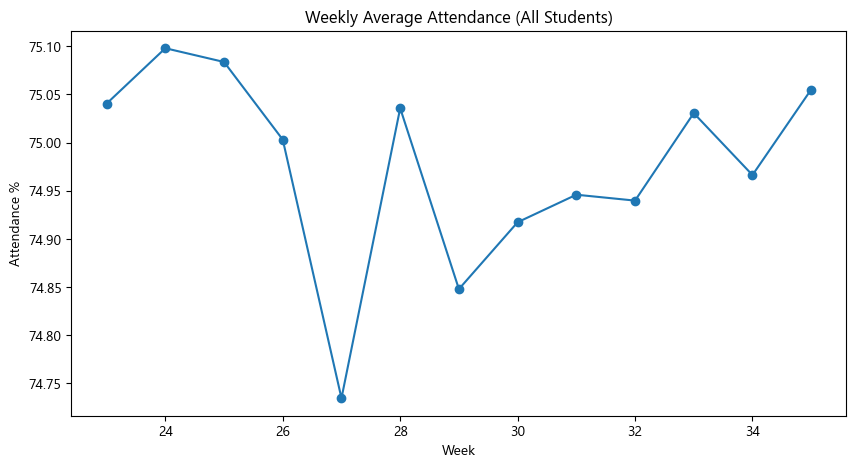

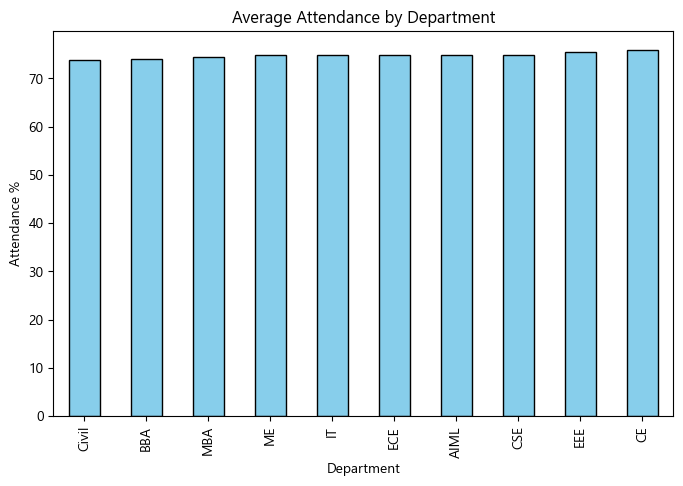

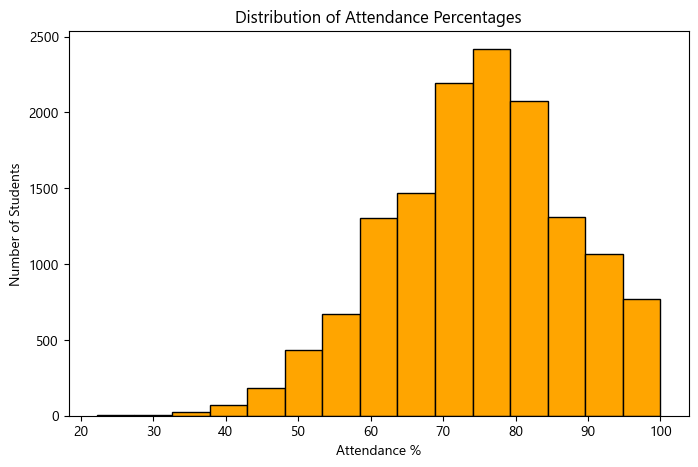

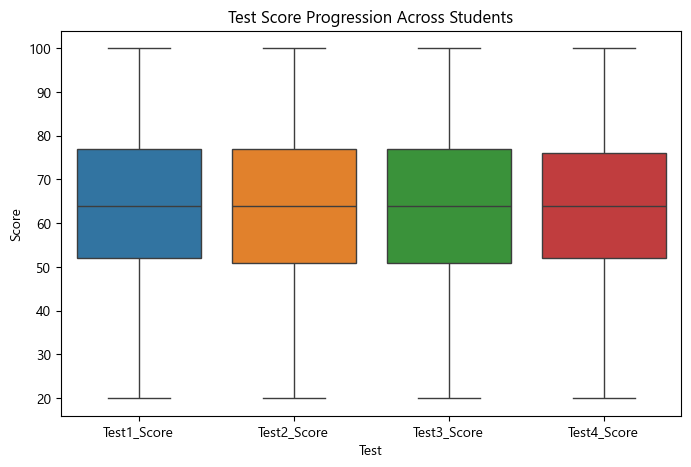

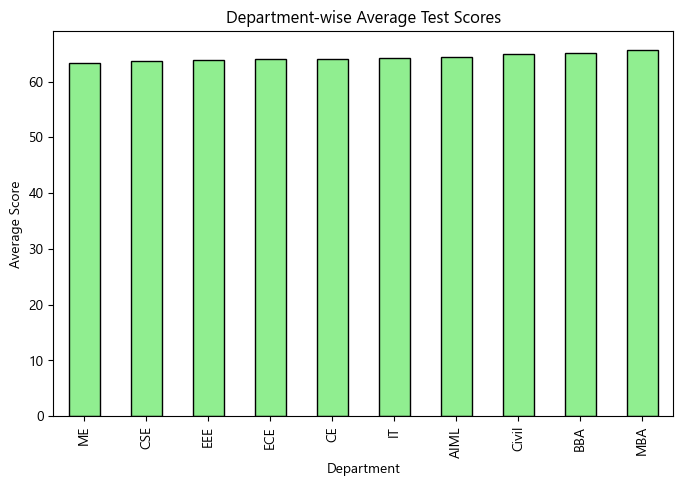

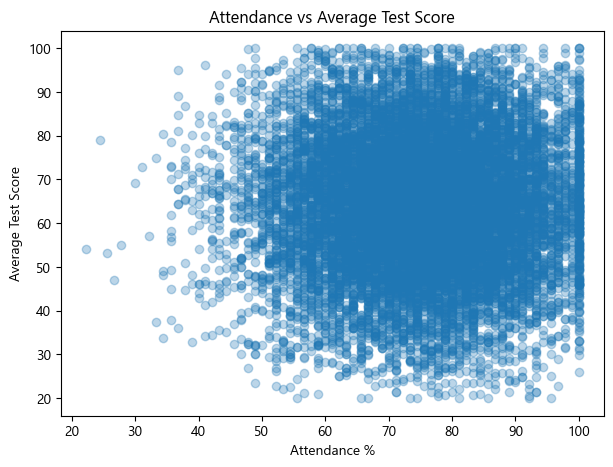

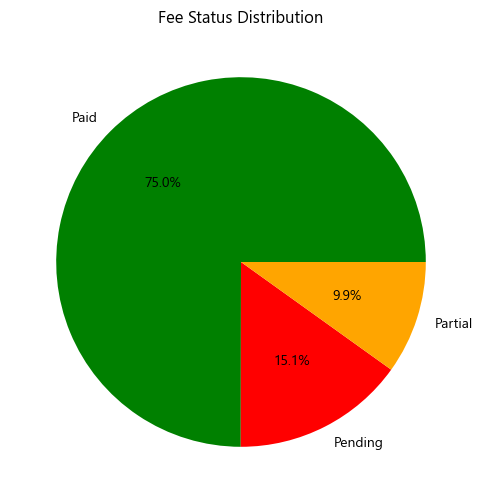

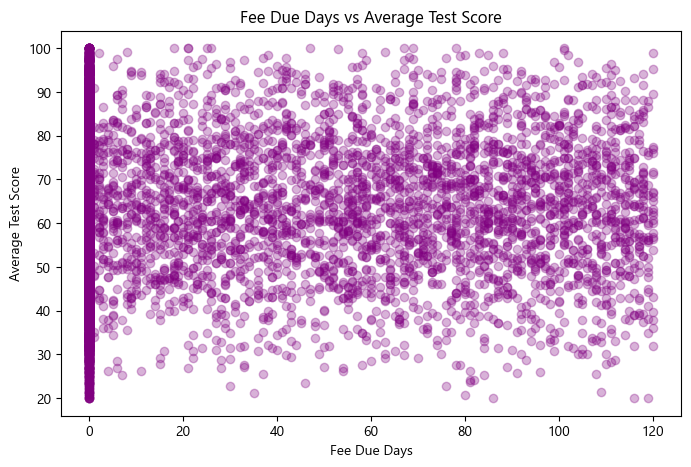

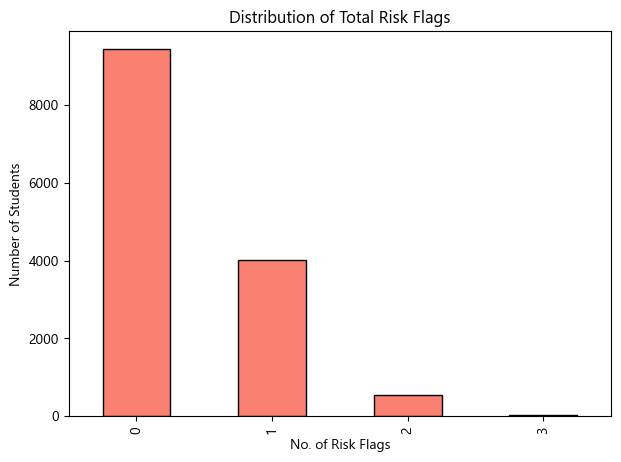

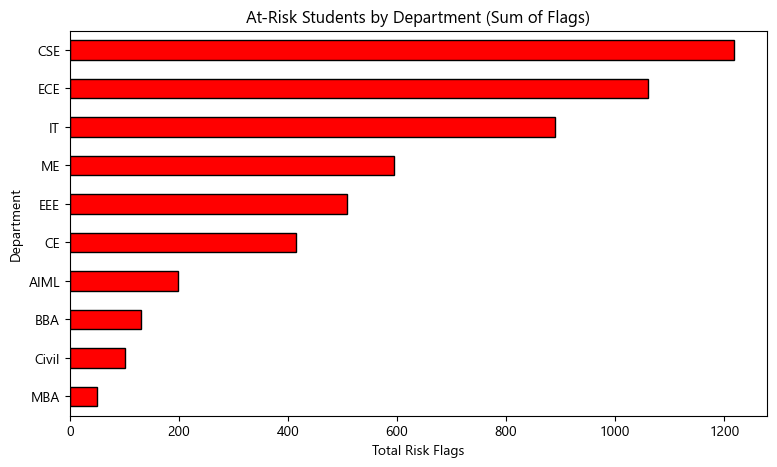

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# =================================================
# 📊 EXTRA TREND ANALYSIS GRAPHS
# =================================================

# 1. Weekly Average Attendance (all students)
attendance_df["week"] = pd.to_datetime(attendance_df["date"]).dt.isocalendar().week
weekly_attendance = attendance_df.groupby("week")["present"].mean() * 100

plt.figure(figsize=(10,5))
weekly_attendance.plot(marker="o")
plt.title("Weekly Average Attendance (All Students)")
plt.ylabel("Attendance %")
plt.xlabel("Week")
plt.show()

# 2. Attendance by Department
dept_attendance = merged.groupby("Department")["Attendance_Percentage"].mean().sort_values()

plt.figure(figsize=(8,5))
dept_attendance.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Attendance by Department")
plt.ylabel("Attendance %")
plt.show()

# 3. Distribution of Attendance Percentages
plt.figure(figsize=(8,5))
plt.hist(merged["Attendance_Percentage"], bins=15, edgecolor="black", color="orange")
plt.title("Distribution of Attendance Percentages")
plt.xlabel("Attendance %")
plt.ylabel("Number of Students")
plt.show()

# 4. Test Score Progression (Test1-Test4)
score_columns = ["Test1_Score", "Test2_Score", "Test3_Score", "Test4_Score"]

tests_melted = tests_df.melt(
    id_vars="Student_ID",
    value_vars=score_columns,
    var_name="Test",
    value_name="Score"
)

plt.figure(figsize=(8,5))
sns.boxplot(data=tests_melted, x="Test", y="Score", hue="Test", legend=False)
plt.title("Test Score Progression Across Students")
plt.show()

# 5. Department-wise Average Test Scores
dept_scores = merged.groupby("Department")["Avg_Test_Score"].mean().sort_values()

plt.figure(figsize=(8,5))
dept_scores.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Department-wise Average Test Scores")
plt.ylabel("Average Score")
plt.show()

# 6. Correlation between Attendance and Scores
plt.figure(figsize=(7,5))
plt.scatter(merged["Attendance_Percentage"], merged["Avg_Test_Score"], alpha=0.3)
plt.title("Attendance vs Average Test Score")
plt.xlabel("Attendance %")
plt.ylabel("Average Test Score")
plt.show()

# 7. Fee Status Distribution
plt.figure(figsize=(6,6))
fees_df["Fee_Status"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["green","red","orange"])
plt.title("Fee Status Distribution")
plt.ylabel("")
plt.show()

# 8. Fee Due Days vs Performance
plt.figure(figsize=(8,5))
plt.scatter(merged["Fee_Due_Days"], merged["Avg_Test_Score"], alpha=0.3, color="purple")
plt.title("Fee Due Days vs Average Test Score")
plt.xlabel("Fee Due Days")
plt.ylabel("Average Test Score")
plt.show()

# 9. Risk Flags Distribution
plt.figure(figsize=(7,5))
merged["Total_Risk_Flags"].value_counts().sort_index().plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Distribution of Total Risk Flags")
plt.xlabel("No. of Risk Flags")
plt.ylabel("Number of Students")
plt.show()

# 10. At-Risk Students by Department
risk_by_dept = merged.groupby("Department")["Total_Risk_Flags"].sum().sort_values()

plt.figure(figsize=(9,5))
risk_by_dept.plot(kind="barh", color="red", edgecolor="black")
plt.title("At-Risk Students by Department (Sum of Flags)")
plt.xlabel("Total Risk Flags")
plt.show()



In [28]:
# =================================================
# 8. Deliver Final Dataset
# =================================================
merged.to_csv("final_clean_students_14k.csv", index=False)
print("✅ Final dataset ready: final_clean_students_14k.csv")
merged.head()


✅ Final dataset ready: final_clean_students_14k.csv


,Student_ID,Name,Roll_No,Department,Semester,Mentor_ID,Attendance_Percentage,Monthly_Attendance,Avg_Test_Score,Last_Test_Score,...,Fee_Paid,Fee_Due_Amount,Fee_Status,Fee_Due_Days,Scholarship_Eligibility,Attendance_Flag,Score_Flag,Attempts_Flag,Fee_Flag,Total_Risk_Flags
0,S00001,Ankita Mishra,R000001,CE,1,M084,72.2,76.7,59.0,59.0,...,50000,0,Paid,0,No,0,0,0,0,0
1,S00002,Kavya Saxena,R000002,ECE,7,M096,81.1,86.7,58.5,58.5,...,50000,0,Paid,0,Yes,0,0,0,0,0
2,S00003,Siddharth Banerjee,R000003,CE,5,M081,75.6,80.0,64.8,64.8,...,24774,30226,Partial,96,No,0,0,0,1,1
3,S00004,Rohan Yadav,R000004,CSE,5,M057,82.2,83.3,86.2,86.2,...,50000,0,Paid,0,No,0,0,0,0,0
4,S00005,Priya Reddy,R000005,IT,7,M106,93.3,93.3,81.8,81.8,...,50000,0,Paid,0,No,0,0,0,0,0
